# Sprawdzenie modelu na testowym dataset


In [82]:
import pathlib
from joblib import load
import pandas as pd
from fastai.tabular.all import *
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pathlib.PosixPath = pathlib.WindowsPath

with open(r"random_forest_drowsiness_model.pkl", "rb") as input_file:
    rf = load(input_file)

nn = load_learner(r"nn_drowsiness_model.pkl")

path = Path(r'E:\Szkoła i Studia\Mechatronika\Semestr 7\Praca dyplomowa\Dataset\tabular_database')

test_df = pd.read_csv(path/'testing_data.csv', index_col=0)

# Przygotowanie danych

In [83]:
def proc_data(df):
    df['Obecne_ziewniecie'] = pd.Categorical(df.Obecne_ziewniecie)
    df['Obecna_sennosc'] = pd.Categorical(df.Obecna_sennosc)
    df = df.drop(columns = ["Obraz"])
    # df = df.rename(columns={"Yawning": "Ziewanie"})
    df = df.drop(columns = ["Obecne_ziewniecie"])
    df = df.rename(columns={"Obecna_sennosc": "Is_drowsy"})
    return df

test_df = proc_data(test_df)
print(test_df.head())

        MAR      Roll     Pitch       EAR   Is_drowsy
0  0.194474  0.164772 -3.569557  0.213012      Drowsy
0  0.120848 -3.610921 -7.526830  0.326617  Not_drowsy
1  0.192915  4.289273  2.194628  0.315493  Not_drowsy
2  0.250130 -3.496078  2.336539  0.312477  Not_drowsy
3  0.243395 -1.352840  4.767441  0.311291  Not_drowsy


In [84]:
def xs_y(df):
    xs = df[continuous].copy()
    return xs, df[dependant] if dependant in df else None

continuous = ['MAR', 'EAR', 'Roll', 'Pitch']
dependant = 'Is_drowsy'

test_xs, test_y = xs_y(test_df)

test_dl = nn.dls.test_dl(test_df)

# Testowanie modeli

## Las losowy

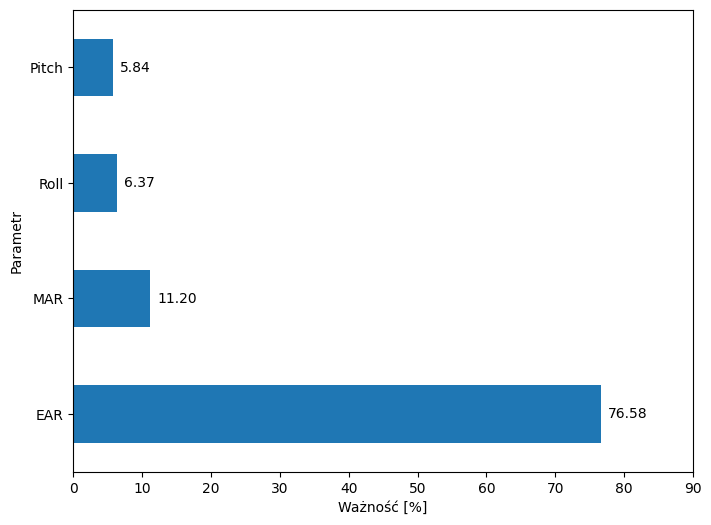

In [85]:
importance = pd.DataFrame(dict(Parametr=test_xs.columns, Znaczenie=rf.feature_importances_*100)).sort_values("Znaczenie", ascending = False)
ax = importance.plot(x='Parametr', y='Znaczenie', kind='barh', legend=False, figsize=(8, 6))
plt.xlabel('Ważność [%]')
ax.bar_label(ax.containers[0], fmt='%.2f', padding=5)
plt.xlim(0, 90)
plt.show()


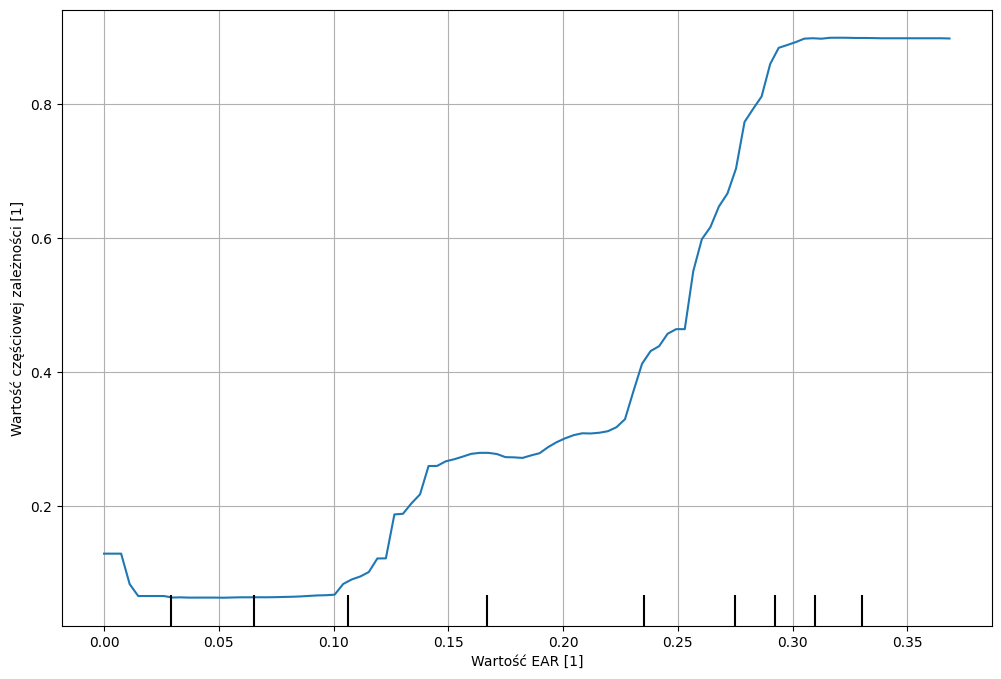

In [86]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(12, 8))

pdp = PartialDependenceDisplay.from_estimator(
    rf,
    test_xs,
    ['EAR'],
    ax=ax,
)

pdp.axes_[0][0].set_ylabel("Wartość częściowej zależności [1]")
pdp.axes_[0][0].set_xlabel("Wartość EAR [1]")
pdp.axes_[0][0].grid(True)
plt.show()


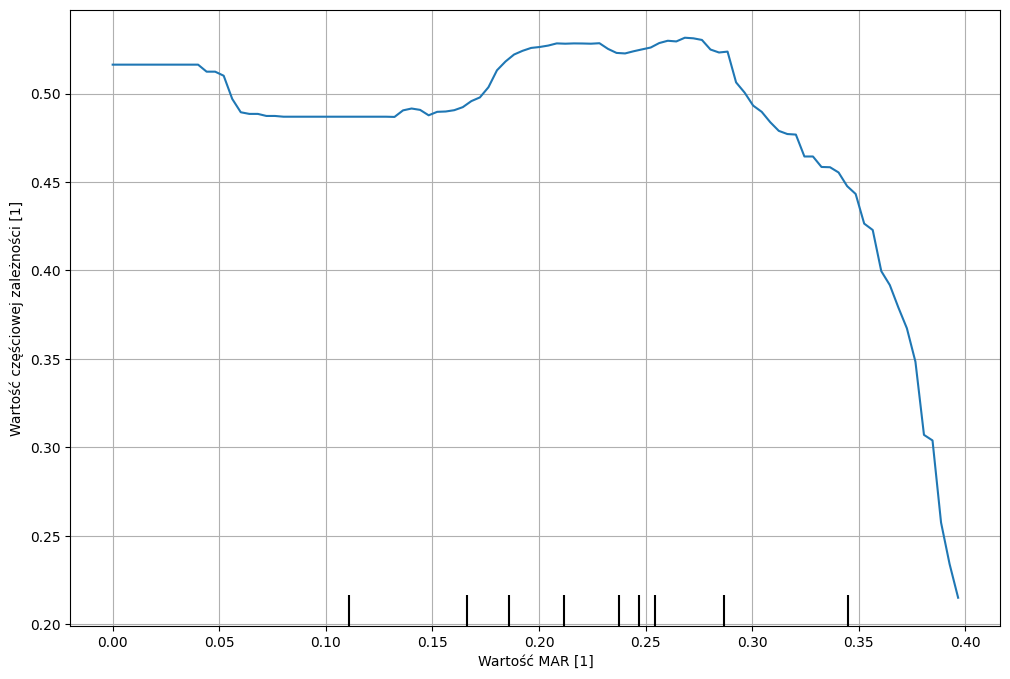

In [87]:
fig, ax = plt.subplots(figsize=(12, 8))

pdp = PartialDependenceDisplay.from_estimator(
    rf,
    test_xs,
    ['MAR'],
    ax=ax,
)

pdp.axes_[0][0].set_ylabel("Wartość częściowej zależności [1]")
pdp.axes_[0][0].set_xlabel("Wartość MAR [1]")
pdp.axes_[0][0].grid(True)
plt.show()

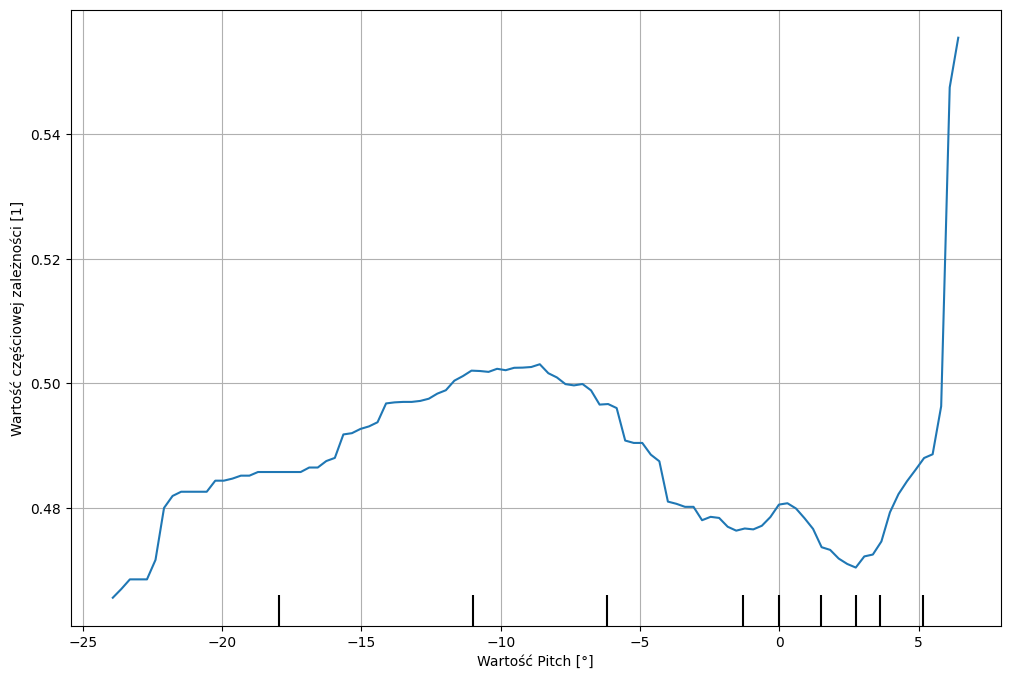

In [88]:
fig, ax = plt.subplots(figsize=(12, 8))

pdp = PartialDependenceDisplay.from_estimator(
    rf,
    test_xs,
    ['Pitch'],
    ax=ax,
)

pdp.axes_[0][0].set_ylabel("Wartość częściowej zależności [1]")
pdp.axes_[0][0].set_xlabel("Wartość Pitch [°]")
pdp.axes_[0][0].grid(True)
plt.show()

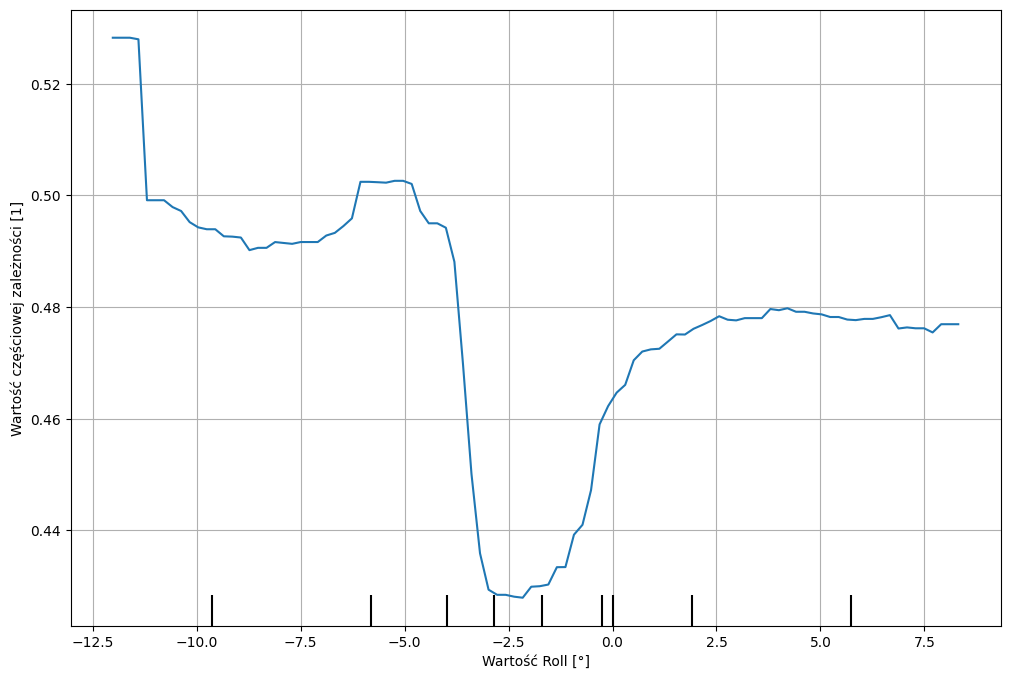

In [89]:
fig, ax = plt.subplots(figsize=(12, 8))

pdp = PartialDependenceDisplay.from_estimator(
    rf,
    test_xs,
    ['Roll'],
    ax=ax,
)

pdp.axes_[0][0].set_ylabel("Wartość częściowej zależności [1]")
pdp.axes_[0][0].set_xlabel("Wartość Roll [°]")
pdp.axes_[0][0].grid(True)
plt.show()

In [90]:
preds_rf = rf.predict(test_xs)

test_y_numeric = test_y

from sklearn.metrics import accuracy_score, zero_one_loss

report_rf = classification_report(test_y_numeric, preds_rf, target_names=rf.classes_, digits=4, zero_division=0)
print("Raport Klasyfikacji (Random Forest):")
print(report_rf)

Raport Klasyfikacji (Random Forest):
              precision    recall  f1-score   support

      Drowsy     0.8491    0.9494    0.8964       237
  Not_drowsy     0.9429    0.8319    0.8839       238

    accuracy                         0.8905       475
   macro avg     0.8960    0.8906    0.8902       475
weighted avg     0.8961    0.8905    0.8902       475



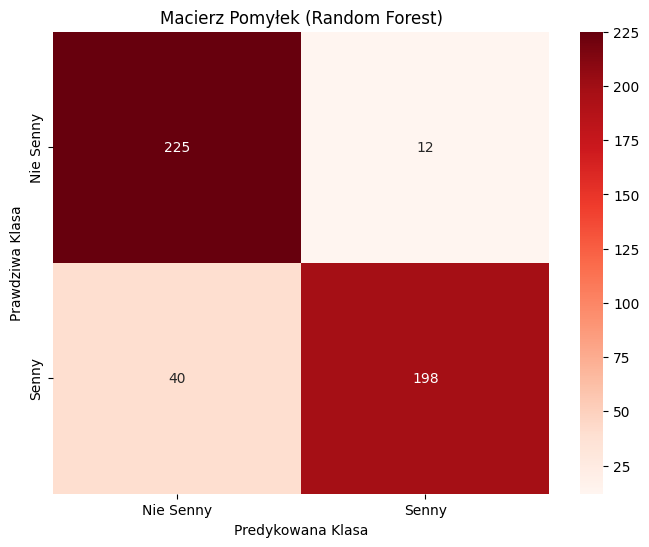

In [91]:
cm_rf = confusion_matrix(test_y_numeric, preds_rf)
class_names_polskie = ['Nie Senny', 'Senny']  # Dostosuj do swoich klas

plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names_polskie,
            yticklabels=class_names_polskie)
plt.xlabel('Predykowana Klasa')
plt.ylabel('Prawdziwa Klasa')
plt.title('Macierz Pomyłek (Random Forest)')
plt.show()

## Sieć neuronowa

In [92]:
preds, targets = nn.get_preds(dl=test_dl)
preds_class = preds.argmax(dim=1).cpu().numpy()
targets_np = targets.cpu().numpy()
report = classification_report(targets_np, preds_class, digits=4)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0     0.8633    0.9325    0.8966       237
           1     0.9269    0.8529    0.8884       238

    accuracy                         0.8926       475
   macro avg     0.8951    0.8927    0.8925       475
weighted avg     0.8952    0.8926    0.8925       475



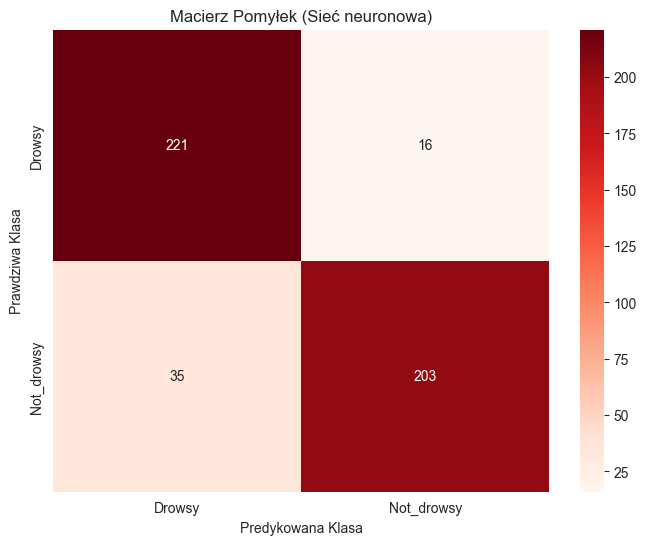

In [94]:
cm = confusion_matrix(targets_np, preds_class)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=nn.dls.vocab,
            yticklabels=nn.dls.vocab)
plt.xlabel('Predykowana Klasa')
plt.ylabel('Prawdziwa Klasa')
plt.title('Macierz Pomyłek (Sieć neuronowa)')
plt.show()